In [16]:
#TODO document jupyter
import torch
import pickle
import configparser
import sqlite3 as sl
import pandas as pd
import numpy as np

In [17]:
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)
datasetPathDatabase =  configParser.get('COMMON', 'datasetPathDatabase') + '/dataset.db'


In [18]:
con = sl.connect(datasetPathDatabase)
data = con.execute("SELECT V.ID, V.VIDEO_PATH, V.AGE, V.ETHNICITY, V.GENDER, A.SPEAKER_EMB, A.LANG, F.FACE_PATH  FROM VIDEO V INNER JOIN AUDIO A ON V.ID = A.VIDEO_ID INNER JOIN FACE F ON V.ID = F.VIDEO_ID")
dataGotten = data.fetchall()

In [19]:
pd.set_option('display.max_columns', None)
df = pd.DataFrame(dataGotten,columns = ['ID','VIDEO_PATH','AGE','ETHNICITY','GENDER','SPEAKER_EMB','LANG','FACE_PATH'])


In [20]:
def speaker_emb_preprocess(speaker_emb2, maxlen=None):
    '''
    A function to take a texual promt and convert it into embeddings
    '''
    #if maxlen is None: maxlen = tokenizer.model_max_length
    #inp = tokenizer(prompts, padding="max_length", max_length=maxlen, truncation=True, return_tensors="pt") 
    #return text_encoder(inp.input_ids.to("cuda"))[0].half()

    speaker_emb2 = speaker_emb2.squeeze()
    speaker_emb2 = np.pad(speaker_emb2, (288), 'constant', constant_values=(0))
    speaker_emb2 = np.tile(speaker_emb2, (256, 1))
    
    
    #speaker_emb2 = torch.from_numpy(speaker_emb2).type(torch.FloatTensor)
    
    #return speaker_emb2.to("cuda").half()
    return speaker_emb2

In [21]:
from PIL import Image
def getImage(face_path):
    im = Image.open(face_path)
    im.load() # required for png.split()

    im2 = Image.new("RGB", im.size, (255, 255, 255))
    im2.paste(im, mask=im.split()[3]) # 3 is the alpha channel
    im3 = np.array(im2)
    im4 = np.rollaxis(im3,2)
    #im4 = torch.from_numpy(im4).type(torch.FloatTensor)
    
    #return im4.to("cuda").half()
    return im4

In [22]:
import torch
from imagen_pytorch import Unet, Imagen
from PIL import Image
import numpy as np
import torchvision
import torchvision.transforms as T
from torchvision.io import read_image


In [25]:
unet1 = Unet(
    dim = 32,
    cond_dim = 512,
    dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = 3,
    layer_attns = (False, True, True, True),
    layer_cross_attns = (False, True, True, True)
)
unet2 = Unet(
    dim = 32,
    cond_dim = 512,
   dim_mults = (1, 2, 4, 8),
    num_resnet_blocks = (2, 4, 8, 8),
    layer_attns = (False, False, False, True),
    layer_cross_attns = (False, False, False, True)
)

# imagen, which contains the unets above (base unet and super resoluting ones)

imagen = Imagen(
    unets = (unet1,unet2),
    image_sizes = (128,128),
    timesteps = 1000,
    cond_drop_prob = 0.1
).cuda()


In [27]:

pd.options.mode.chained_assignment = None
for epoch in range(25):
    for index, row in df.iterrows():
        df2 = df.iloc[[index]]
        df2['SPEAKER_EMB'] = df2['SPEAKER_EMB'].apply(lambda x:pickle.loads(x))
        df2['SPEAKER_EMB'] = df2['SPEAKER_EMB'].apply(lambda x:speaker_emb_preprocess(x))
        df2['IMAGE'] = df2['FACE_PATH'].apply(lambda x:getImage(x) )
        input = df2['IMAGE'].to_numpy()
        input = input.tolist()
        output = df2['SPEAKER_EMB'].to_numpy()
        output = output.tolist()
        input= np.asarray(input, dtype=np.uint8)
        output= np.asarray(output, dtype=np.float32)

        input = torch.from_numpy(input).type(torch.FloatTensor).to("cuda")
        #input = input.to("cuda").half()
        output = torch.from_numpy(output).type(torch.FloatTensor).to("cuda")
        #output = output.to("cuda").half()
        print("Batch number " + str(index) + " in epoch number " + str(epoch))

        for i in (1, 2):

            loss = imagen(input, text_embeds = output, unet_number = 1)
            loss.backward()

        del input
        del output
print("")


Batch number 0 in epoch number 0
Batch number 1 in epoch number 0
Batch number 2 in epoch number 0
Batch number 3 in epoch number 0
Batch number 4 in epoch number 0
Batch number 5 in epoch number 0
Batch number 6 in epoch number 0
Batch number 7 in epoch number 0
Batch number 8 in epoch number 0
Batch number 9 in epoch number 0
Batch number 10 in epoch number 0
Batch number 11 in epoch number 0
Batch number 12 in epoch number 0
Batch number 13 in epoch number 0
Batch number 14 in epoch number 0
Batch number 15 in epoch number 0
Batch number 16 in epoch number 0
Batch number 17 in epoch number 0
Batch number 18 in epoch number 0
Batch number 19 in epoch number 0
Batch number 20 in epoch number 0
Batch number 21 in epoch number 0
Batch number 22 in epoch number 0
Batch number 23 in epoch number 0
Batch number 24 in epoch number 0
Batch number 25 in epoch number 0
Batch number 26 in epoch number 0
Batch number 27 in epoch number 0
Batch number 28 in epoch number 0
Batch number 29 in epoch

KeyboardInterrupt: 

In [11]:
df2 = df.head(1)
df2['SPEAKER_EMB'] = df2['SPEAKER_EMB'].apply(lambda x:pickle.loads(x))
df2['SPEAKER_EMB'] = df2['SPEAKER_EMB'].apply(lambda x:speaker_emb_preprocess(x))
df2['IMAGE'] = df2['FACE_PATH'].apply(lambda x:getImage(x) )
input = df2['IMAGE'].to_numpy()
input = input.tolist()
output = df2['SPEAKER_EMB'].to_numpy()
output = output.tolist()
input= np.asarray(input, dtype=np.uint8)
output= np.asarray(output, dtype=np.float32)

input = torch.from_numpy(input).type(torch.FloatTensor).to("cuda")
#input = input.to("cuda").half()
output = torch.from_numpy(output).type(torch.FloatTensor).to("cuda")
#output = output.to("cuda").half()




In [12]:
images = imagen.sample( text_embeds = output, cond_scale = 3.)
del input
del output

sampling loop time step: 100%|██████████| 1000/1000 [01:36<00:00, 10.32it/s]
1it [01:37, 97.17s/it]


In [13]:
images.shape

torch.Size([1, 3, 128, 128])

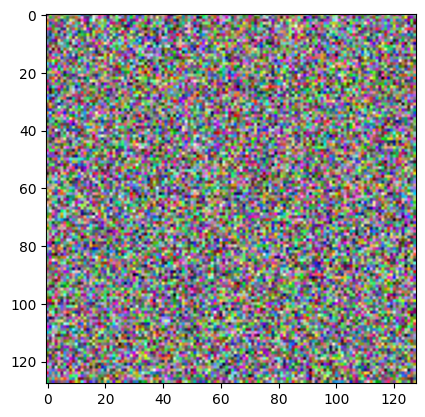

In [15]:
from matplotlib import pyplot as plt
plt.imshow(  images[0].cpu().permute(1, 2, 0)  )